<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/nlp/pytorch-seq2seq/3_Neural_Machine_Translation_by_Jointly_Learning_to_Align_and_Translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference [Bentrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

[NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE](https://arxiv.org/pdf/1409.0473.pdf)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from tqdm import tqdm
import random
import math
import time

In [ ]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [ ]:

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    v2 = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    v2.set_default_index(0)
    return v2

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de)],
                                dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                                dtype=torch.long)
        data.append((de_tensor_, en_tensor_))
    return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

In [ ]:
len(de_vocab)

19215

In [ ]:
BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
class Encoder(nn.Module):
    def __init__(self,input_dim,embed_dim,enc_hid_dim,dec_hic_dim,dropout):
        super(Encoder,self).__init__()

        self.embedding = nn.Embedding(input_dim,embed_dim)

        self.rnn = nn.GRU(embed_dim,enc_hid_dim,bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2,dec_hic_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,src):
        #src = [src len ,batch_size]
        embedded = self.dropout(self.embedding(src))

        #embedded = [src len ,batch_size,embedded_dim]
        outputs , hidden = self.rnn(embedded)

        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]

        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer

        #hidden [-2, :, : ] is the last of the forwards RNN
        #hidden [-1, :, : ] is the last of the backwards RNN

        #initial decoder hidden is final hidden state of the forwards and backwards
        #  encoder RNNs fed through a linear layer

        hidden = torch.tanh(self.fc(torch.cat([hidden[-2,:,:],hidden[-1,:,:]],dim = 1)))

        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        return outputs,hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self,enc_hid_dim,dec_hid_dim):
        super().__init__()
        self.att = nn.Linear((enc_hid_dim * 2) + dec_hid_dim,dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim,1,bias = False)
    def forward(self,hidden,encoder_outputs):
        #hidden = [batch_size,dec_hid dim]
        #encoder_outputs = [src len,batch size,encoder hid dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1)
        #hidden = torch.Size([batch size, 1, dec_hid dim])
        #repeat decoder hidden states src_len times
        hidden = hidden.repeat(1,src_len,1)
        #hidden = torch.Size([batch size, seq len, dec_hid dim])

        encoder_outputs = encoder_outputs.permute(1,0,2)
        #encoder_outputs = [batch size,src len,encoder hid dim * 2]

        energy = torch.tanh(self.att(torch.cat((hidden,encoder_outputs),dim = 2)))
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy)
        #attention = [batch size, src len, 1]

        attention = attention.squeeze(2)
        #attention = [batch size, src len]
        return F.softmax(attention,dim=1)


In [ ]:
class Decoder(nn.Module):
    def __init__(self,output_dim,emb_dim,enc_hid_dim,dec_hid_dim,dropout,attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim,emb_dim)
        self.rnn = nn.GRU((enc_hid_dim*2)+ emb_dim,dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim*2)+ dec_hid_dim + emb_dim,output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self,input,hidden,encoder_outputs):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        input = input.unsqueeze(0)
        #input = [1,batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1,batch size,embed_dim]

        a = self.attention(hidden,encoder_outputs)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1,0,2)
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a,encoder_outputs)
        #[batch size,1 ,enc hid dim * 2]

        weighted = weighted.permute(1,0,2)
        #[1 ,batch size,enc hid dim * 2]

        rnn_input = torch.cat((embedded,weighted),dim=2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output,hidden = self.rnn(rnn_input,hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()

        embedded = embedded.squeeze(0) #[batch size,embed_dim]
        output = output.squeeze(0)     #[batch size, dec hid dim]
        weighted = weighted.squeeze(0) #[batch size,enc hid dim * 2]

        out_cat = torch.cat((output,weighted,embedded),dim = 1)
        #out_cat = [batch size,(enc hid dim * 2)+dec hid dim+embed_dim]
        prediction = self.fc_out(out_cat)
        #prediction = [batch size,out dim]
        return prediction , hidden.squeeze(0)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
    def forward(self,src,trg,teacher_forcing_ratio = 0.5):
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len,batch_size,trg_vocab_size).to(device)

        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs,hidden = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]

        for t in range(1,trg_len):
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output,hidden = self.decoder(input,hidden,encoder_outputs)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input =trg[t] if teacher_force else top1
        return outputs

In [ ]:
INPUT_DIM =  len(de_vocab)
OUTPUT_DIM = len(en_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# outputs,hidden = enc(x.T)
# input = y[:,0]
enc = Encoder(INPUT_DIM,ENC_EMB_DIM,ENC_HID_DIM,DEC_HID_DIM,ENC_DROPOUT)
# outputs,hidden = enc(x)
att = Attention(ENC_HID_DIM,DEC_HID_DIM)
# a = att(hidden,outputs)
dec = Decoder(OUTPUT_DIM,DEC_EMB_DIM,ENC_HID_DIM,DEC_HID_DIM,DEC_DROPOUT,att)

# pred,hidden = dec(input,hidden,outputs)
model = Seq2Seq(enc,dec).to(device)

In [ ]:
def init_weights(m:nn.Module):
    for name,param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
init_weights(model)

In [ ]:
def count_paramters(model:nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_paramters(model)

33559382

In [ ]:
TRG_PAD_IDX = en_vocab.get_stoi()['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from tqdm import tqdm

In [ ]:
def train(model:nn.Module,
          iterator :torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
        criterion : nn.Module,
          clip:float
          ):

    model.train()

    epoch_loss = 0

    for _, (src, trg) in enumerate(tqdm(iterator)):
        src,trg = src.to(device),trg.to(device)
        optimizer.zero_grad()
        output = model(src,trg)
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output = output[1:].view(-1,output.shape[-1])
        trg = trg[1:].view(-1)

        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]

        loss = criterion(output,trg)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model:nn.Module,
             iterator:torch.utils.data.DataLoader,
             criterion : nn.Module
             ):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for _, (src, trg) in enumerate(tqdm(iterator)):
            src,trg = src.to(device),trg.to(device)
            output = model(src,trg,0)  #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output = output[1:].view(-1,output.shape[-1])
            target = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output,target)

            epoch_loss += loss.item()
    return epoch_loss/len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_losses = []
val_losses = []
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


Epoch: 01 | Time: 2m 8s
	Train Loss: 4.974 | Train PPL: 144.654
	 Val. Loss: 4.961 |  Val. PPL: 142.777


100%|██████████| 8/8 [00:02<00:00,  4.00it/s]


Epoch: 02 | Time: 2m 9s
	Train Loss: 4.165 | Train PPL:  64.415
	 Val. Loss: 4.617 |  Val. PPL: 101.165


100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


Epoch: 03 | Time: 2m 9s
	Train Loss: 3.750 | Train PPL:  42.512
	 Val. Loss: 4.324 |  Val. PPL:  75.521


100%|██████████| 8/8 [00:01<00:00,  4.00it/s]


Epoch: 04 | Time: 2m 9s
	Train Loss: 3.224 | Train PPL:  25.121
	 Val. Loss: 3.904 |  Val. PPL:  49.624


100%|██████████| 8/8 [00:02<00:00,  3.62it/s]


Epoch: 05 | Time: 2m 9s
	Train Loss: 2.780 | Train PPL:  16.122
	 Val. Loss: 3.714 |  Val. PPL:  41.034


100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Epoch: 06 | Time: 2m 9s
	Train Loss: 2.360 | Train PPL:  10.588
	 Val. Loss: 3.635 |  Val. PPL:  37.883


100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


Epoch: 07 | Time: 2m 10s
	Train Loss: 2.053 | Train PPL:   7.794
	 Val. Loss: 3.514 |  Val. PPL:  33.575


100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


Epoch: 08 | Time: 2m 10s
	Train Loss: 1.796 | Train PPL:   6.024
	 Val. Loss: 3.568 |  Val. PPL:  35.434


100%|██████████| 8/8 [00:02<00:00,  3.91it/s]


Epoch: 09 | Time: 2m 9s
	Train Loss: 1.599 | Train PPL:   4.950
	 Val. Loss: 3.614 |  Val. PPL:  37.099


100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

Epoch: 10 | Time: 2m 10s
	Train Loss: 1.460 | Train PPL:   4.307
	 Val. Loss: 3.643 |  Val. PPL:  38.224


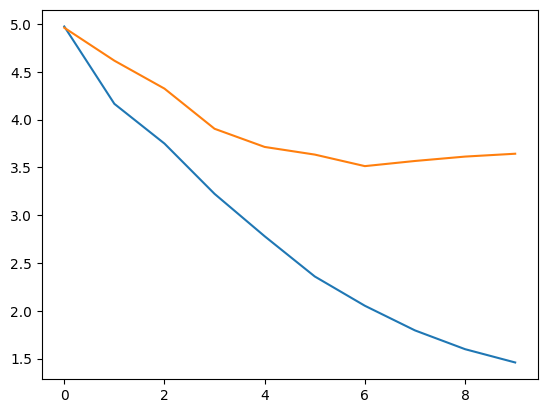

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
# Define the translation function
def translate_sentence(model, src_sentence,device, max_len=50):
    model.eval()
    with torch.no_grad():
        if isinstance(src_sentence, str):
            tokens = de_tokenizer(src_sentence)
        else:
            tokens = src_sentence


        tokens = ['<bos>'] + tokens + ['<eos>']
        src_indexes = de_vocab.lookup_indices(tokens)

        src_tensor = torch.tensor(src_indexes).unsqueeze(1).to(device)


        with torch.no_grad():
            encoder_outputs, hidden = model.encoder(src_tensor)


        BOS_INDEX = en_vocab.get_stoi()["<bos>"]

        trg_indexes = [BOS_INDEX]

        for i in range(max_len):

            trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
            with torch.no_grad():
                output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)


            pred_token = output.argmax(1).item()

            trg_indexes.append(pred_token)

            if pred_token == en_vocab.get_stoi()["<eos>"]:
                break

    trg_tokens = en_vocab.lookup_tokens(trg_indexes)

    return trg_tokens[1:]

In [ ]:
def get_test_data(filepaths): #test_filepaths
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    return raw_de_iter,raw_en_iter


In [ ]:
test_x,test_y = get_test_data(test_filepaths)
src_arr = []
trg_arr = []
for x,y in zip(test_x,test_y):
    src_arr.append(x)
    trg_arr.append(y)

In [ ]:
example_idx = 10
src = src_arr[example_idx]
trg = trg_arr[example_idx]

translation = translate_sentence(model,src, device)
print('src:',src)
print('trg:',trg)
print(f'predicted trg = {translation}')

src: Eine Mutter und ihr kleiner Sohn genießen einen schönen Tag im Freien.

trg: A mother and her young song enjoying a beautiful day outside.

predicted trg = ['A', 'mother', 'and', 'her', 'son', 'enjoying', 'enjoying', 'a', 'hot', 'day', 'day', '.', '\n', '<eos>']


In [ ]:
example_idx = 12
src = src_arr[example_idx]
trg = trg_arr[example_idx]

translation = translate_sentence(model,src, device)
print('src:',src)
print('trg:',trg)
print(f'predicted trg = {translation}')

src: Eine Frau, die in einer Küche eine Schale mit Essen hält.

trg: A woman holding a bowl of food in a kitchen.

predicted trg = ['A', 'woman', 'holding', 'a', 'dish', 'in', 'a', 'kitchen', 'holding', 'food', '.', '\n', '<eos>']


In [33]:
example_idx = 14
src = src_arr[example_idx]
trg = trg_arr[example_idx]

translation = translate_sentence(model,src, device)
print('src:',src)
print('trg:',trg)
print(f'predicted trg = {translation}')

src: Drei Leute sitzen in einer Höhle.

trg: Three people sit in a cave.

predicted trg = ['Three', 'people', 'are', 'sitting', 'in', 'a', 'mall', '.', '\n', '<eos>']


In [34]:
example_idx = 15
src = src_arr[example_idx]
trg = trg_arr[example_idx]

translation = translate_sentence(model,src, device)
print('src:',src)
print('trg:',trg)
print(f'predicted trg = {translation}')

src: Ein Mädchen in einem Jeanskleid läuft über einen erhöhten Schwebebalken.

trg: A girl in a jean dress is walking along a raised balance beam.

predicted trg = ['A', 'girl', 'in', 'a', 'denim', 'dress', 'runs', 'across', 'a', 'piece', 'of', 'beam', '.', '\n', '<eos>']
